<a href="https://colab.research.google.com/github/dominiksakic/NETworkingMay/blob/main/20_stacked_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-05-24 07:04:14--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.133.216, 52.217.169.216, 16.15.185.166, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.133.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  61.9MB/s    in 0.2s    

2025-05-24 07:04:15 (61.9 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [10]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))

for idx, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[idx] = values [1]
  raw_data[idx, :] = values[:]

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

# prepare the data
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Normalize data, only on the train_samples NO DATA LEAKAGE
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 361s 430ms/step - loss: 44.9845 - mae: 4.9804 - val_loss: 9.5663 - val_mae: 2.3890
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 345s 386ms/step - loss: 14.8120 - mae: 2.9911 - val_loss: 9.0308 - val_mae: 2.3269
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 318s 387ms/step - loss: 13.5507 - mae: 2.8563 - val_loss: 8.9464 - val_mae: 2.3174
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 318s 388ms/step - loss: 12.8277 - mae: 2.7766 - val_loss: 9.1560 - val_mae: 2.3529
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 351s 428ms/step - loss: 12.2354 - mae: 2.7084 - val_loss: 9.0130 - val_mae: 2.3237
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 348s 387ms/step - loss: 11.6449 - mae: 2.6494 - val_loss: 8.8953 - val_mae: 2.3111
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 355s 434ms/step - loss: 11.1840 - mae: 2.5935 - val_loss: 9.0569 - val_mae: 2.3357
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 342s 385ms/step - loss: 10.7829 - mae: 2.5474 - val_loss: 9.1619 - val_mae: 2.3496
Epoch 9/50
819/8

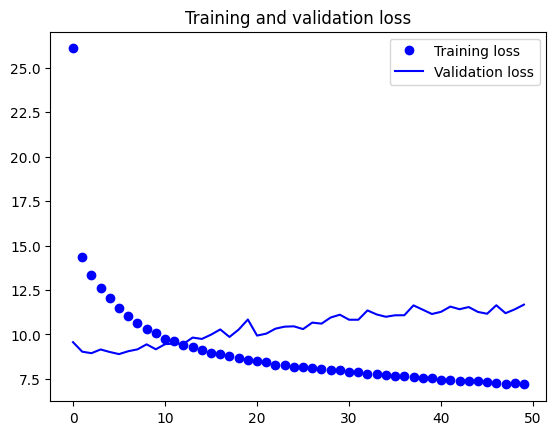

In [16]:
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

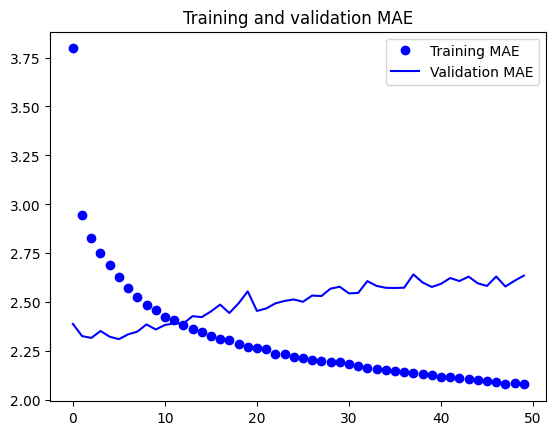

In [18]:
mae = history["mae"]
val_mae = history["val_mae"]
plt.figure()
plt.plot(epochs, mae, "bo", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [19]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 57s 134ms/step - loss: 9.9448 - mae: 2.4711
Test MAE: 2.46
